In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url1 = 'https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/flights.csv'
url2 = 'https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/weather.csv'
    
flights = pd.read_csv(url1, sep=',')
weather = pd.read_csv(url2, sep=',')

В нашем отчете мы рассмотрим всевозможные зависимости задержек рейсов от условий погоды, дней года и часов в течение дня.
Также посмотрим на распределенеи рейсов по аэропортам и возможные пути решения проблем.

In [6]:

amountofdelperday=flights.groupby(flights[flights.dep_delay>0].hour)['dep_delay'].size().reset_index(name='AmountOfDel')
amountpd=flights.groupby(flights.hour)['dep_delay'].size().reset_index(name='Amount')
flights_merge=pd.merge(amountofdelperday, amountpd, on='hour')
amountofdel=flights_merge['AmountOfDel'].sum()
amountofflights=flights_merge['Amount'].sum()
flights_merge['Percentage_of_delay']=(flights_merge.AmountOfDel/flights_merge.Amount)*100

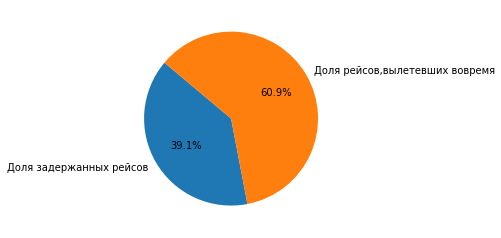

In [14]:
plt.pie([amountofdel,amountofflights-amountofdel], labels=['Доля задержанных рейсов','Доля рейсов,вылетевших вовремя'], autopct='%1.1f%%', shadow=False, startangle=140)
plt.show()

Начинаем наш отчет с замечания, что ежегодно более трети рейсов взлетают с задержкой. Это говорит о том, что не бесполезно исследовать вопросы оптимизации воздушно-транспортного сообщения

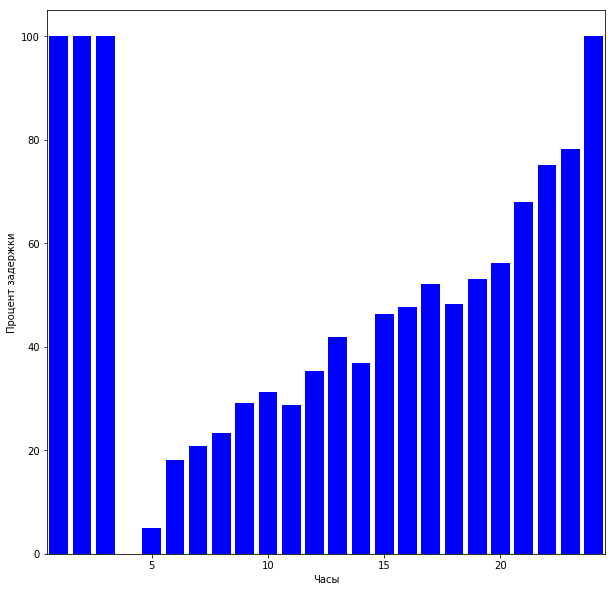

In [47]:
plt.figure(figsize=(10,10))
plt.bar(flights_merge.hour, flights_merge.Percentage_of_delay, color='blue')
plt.xlabel('Часы')
plt.ylabel('Процент задержки')
plt.xlim(0.5,24.5)
plt.show()

Вывод: надо разгрузить ранне утро и поздний вечер

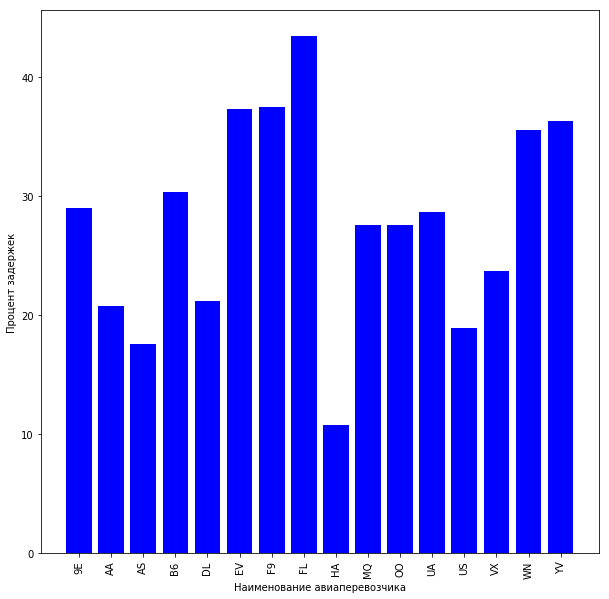

In [169]:
flights1=flights[(flights.dep_delay>0) & (flights.arr_delay>0)]
amountofdelpercar=flights1.groupby('carrier').size().reset_index(name='AmountOfDel')
flights2=flights[np.isfinite(flights['dep_time'])]
amountpercar=flights2.groupby('carrier').size().reset_index(name='Amount')
carmerge=pd.merge(amountofdelpercar, amountpercar, on=['carrier'])
carmerge['Percentage']=(carmerge.AmountOfDel/carmerge.Amount)*100
ind = np.arange(len(carmerge.carrier))
plt.figure(figsize=(10,10))
plt.bar(ind, carmerge.Percentage, color='blue')
plt.xticks(ind, carmerge.carrier, rotation='vertical')
plt.ylabel('Процент задержек')
plt.xlabel('Наименование авиаперевозчика')
plt.show()

Вывод: надо вести работу с компаниями, процент задержки рейсов которых больше 30

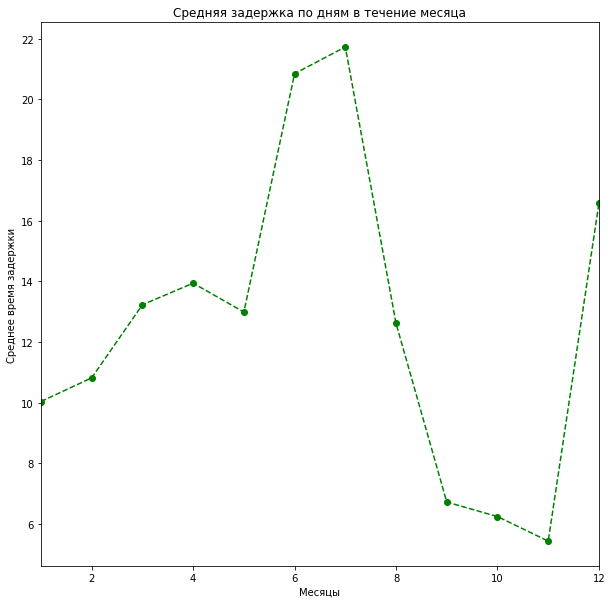

In [74]:
grouped_flights=flights.groupby('month')['dep_delay'].mean().reset_index(name='Daily_mean_delay')
plt.figure(figsize=(10,10))
plt.plot(grouped_flights.month, grouped_flights.Daily_mean_delay, 'go--')
plt.xlim(1,12)
plt.title('Средняя задержка по дням в течение месяца')
plt.xlabel('Месяцы')
plt.ylabel('Среднее время задержки')
plt.show()

Заметим, что середина года-интенсивный период. Это означает, что к обслуживанию аэропортов и рейсов надо привлекать больше рабочих

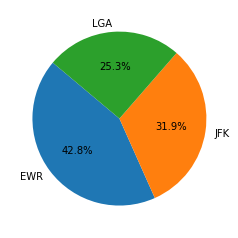

In [116]:
gr_by_or=flights.groupby('origin').sum()['dep_delay'].reset_index(name='Amount')
col=gr_by_or.Amount
plt.pie([col[0],col[1],col[2]], labels=gr_by_or.origin, autopct='%1.1f%%', shadow=False, startangle=140)
plt.show()

Данная диаграмма говорит о том, что можно было бы разгрузить EWR. Дальнейшее исследование покажет, в какие месяцы и какие аэропорты это можно будет сделать

In [119]:
ewr=flights[flights.origin=='EWR']
jfk=flights[flights.origin=='JFK']
lga=flights[flights.origin=='LGA']

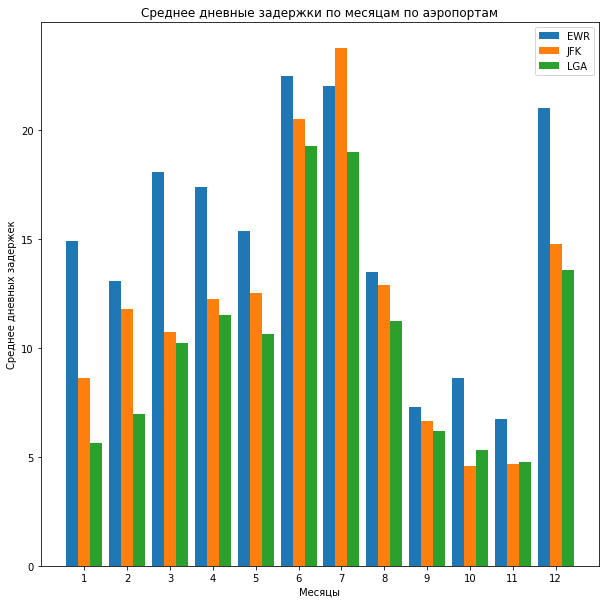

In [138]:
ewr_del=ewr.groupby('month')['dep_delay'].mean().reset_index(name='Daily_mean_delay')
jfk_del=jfk.groupby('month')['dep_delay'].mean().reset_index(name='Daily_mean_delay')
lga_del=lga.groupby('month')['dep_delay'].mean().reset_index(name='Daily_mean_delay')
ind=np.arange(12)
width=0.28
plt.figure(figsize=(10,10))
plt.bar(ind, ewr_del.Daily_mean_delay, width, label='EWR')
plt.bar(ind+width, jfk_del.Daily_mean_delay, width, label='JFK')
plt.bar(ind+2*width, lga_del.Daily_mean_delay, width, label='LGA')
plt.xticks(ind+width, ind+1)
plt.ylabel('Среднее дневных задержек')
plt.xlabel('Месяцы')
plt.title('Среднее дневные задержки по месяцам по аэропортам')
plt.legend(loc='best')
plt.show()

Таким образом, в предположении о том, что аэропорты работают эффективно и причинами задержек не являются ленивые сотрудники,
имеет смысл разгрузить EWR только в первой половине года и в декабре. Рассмотрим связь с погодой

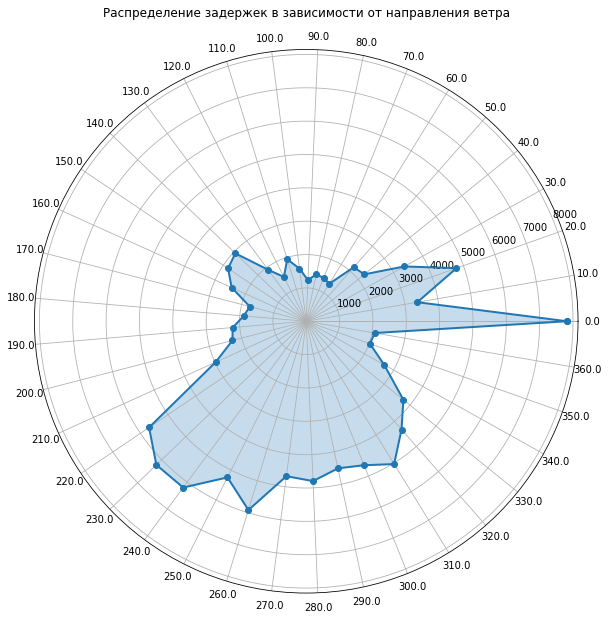

In [141]:
del_fl=flights[flights.dep_delay>0]
grouped=del_fl.groupby(['origin', 'month', 'day','hour'])['dep_delay'].agg([np.size, np.mean]).reset_index()
#merged=merged.drop(['Unnamed: 0', 'origin_y', 'year'], axis=1)
merged=merged.rename(columns={'origin_x':'origin'})
by_dir=merged.groupby('wind_dir')['size'].sum().reset_index(name='Count')

labels=np.linspace(0,360,37)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats=np.array(by_dir.Count)
stats = np.concatenate((stats,[stats[0]]))
angles = np.array(np.concatenate((angles,[angles[0]])))

fig= plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('Распределение задержек в зависимости от направления ветра')
ax.grid(True)
plt.show()


Подобная информация говорит нам о том, что если вдруг будет затеваться постройка новой ВПП, то ее азимут должен будет четко выверяться во избежание бокового ветра при приземлении бортов

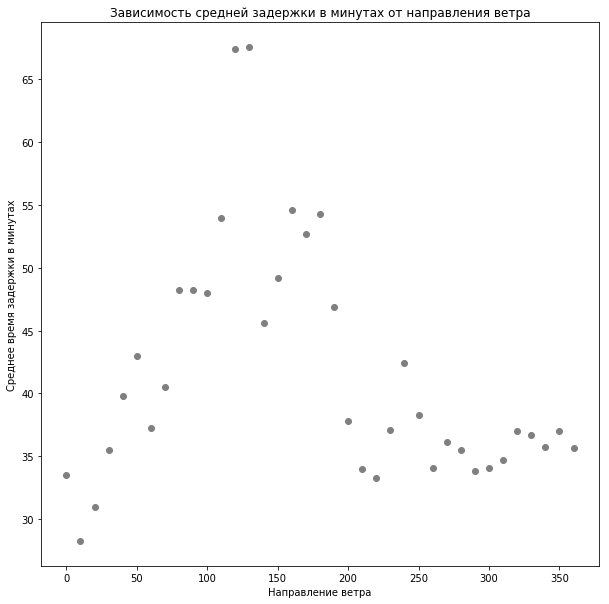

In [160]:
by_dir1=merged.groupby('wind_dir')['mean'].mean().reset_index(name='MeanDelay')

plt.figure(figsize=(10,10))
plt.scatter(by_dir1.wind_dir, by_dir1.MeanDelay, c='grey')

plt.title('Зависимость средней задержки в минутах от направления ветра')
plt.xlabel('Направление ветра')
plt.ylabel('Среднее время задержки в минутах')
plt.show()

Видим интересную картину:несмотря на то, что большинство задержек относительно направления ветра пришлось на угол 0, самые длительные задержки приходятся на промежуток 100-150 градусов. Но как же коррелируют между собой время задержки и их количество?

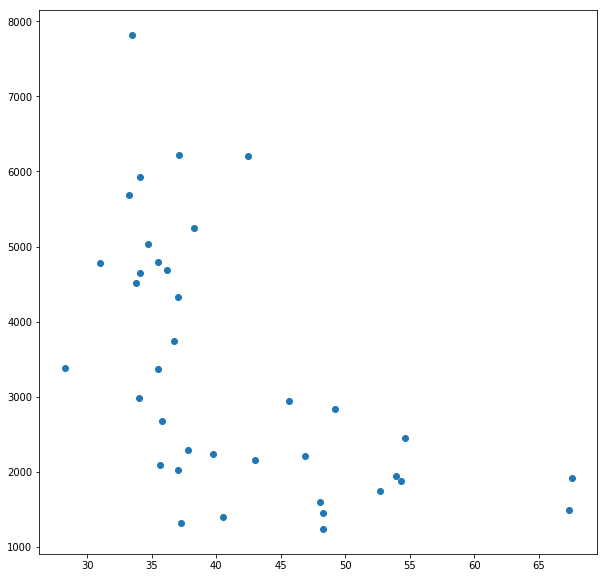

In [161]:
plt.figure(figsize=(10,10))
plt.scatter(by_dir1.MeanDelay, by_dir.Count)
plt.show()

Вот так!

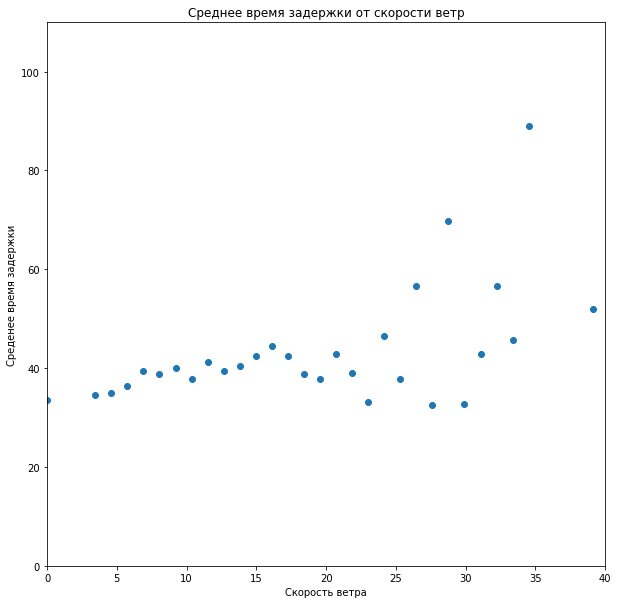

In [167]:
by_speed=merged.groupby('wind_speed')['mean'].mean().reset_index(name='MeanDelay')
plt.figure(figsize=(10,10))
plt.scatter(by_speed.wind_speed, by_speed.MeanDelay)
plt.xlim(0,40)
plt.ylim(0,110)
plt.title('Среднее время задержки от скорости ветр')
plt.xlabel('Скорость ветра')
plt.ylabel('Среденее время задержки')
plt.show()

Получили интересную зависимость: начиная с 30 миль в час уже даже для больших самолетов появляется риск неудачного взлета, тем самым время задержек растет